In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# PART 1: Build and train an autoencoder as a pre-training step using Sequential API
def build_encoder():
    encoder = Sequential(name='encoder')

    # First block
    encoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((2, 2)))  # 16x16

    # Second block
    encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((2, 2)))  # 8x8

    # Third block
    encoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((2, 2)))  # 4x4

    # Bottleneck
    encoder.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.BatchNormalization())

    return encoder

def build_decoder():
    decoder = Sequential(name='decoder')

    # Start from bottleneck representation
    decoder.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(4, 4, 256)))
    decoder.add(layers.BatchNormalization())

    # First upsampling block
    decoder.add(layers.UpSampling2D((2, 2)))  # 8x8
    decoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())

    # Second upsampling block
    decoder.add(layers.UpSampling2D((2, 2)))  # 16x16
    decoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())

    # Third upsampling block
    decoder.add(layers.UpSampling2D((2, 2)))  # 32x32
    decoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.BatchNormalization())

    # Output layer
    decoder.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return decoder

def build_autoencoder():
    # Create the encoder and decoder
    encoder = build_encoder()
    decoder = build_decoder()

    # Create the full autoencoder using Sequential API
    autoencoder = Sequential(name='autoencoder')

    # Add all encoder layers
    for layer in encoder.layers:
        autoencoder.add(layer)

    # Add all decoder layers
    for layer in decoder.layers:
        autoencoder.add(layer)

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

# Function to train the autoencoder
def train_autoencoder(autoencoder, epochs=20, batch_size=128):
    # Create data generator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Train the autoencoder
    history = autoencoder.fit(
        datagen.flow(train_images, train_images, batch_size=batch_size),
        epochs=epochs,
        validation_data=(test_images, test_images),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        ]
    )

    return history

# PART 2: Build a fully convolutional classifier using the pre-trained encoder
def build_fcn_classifier(pre_trained_encoder, trainable_base=False):
    # Set the encoder layers to be trainable or not
    pre_trained_encoder.trainable = trainable_base

    # Create the classifier model
    fcn_classifier = Sequential(name='fcn_classifier')

    # Add the pre-trained encoder layers
    for layer in pre_trained_encoder.layers:
        fcn_classifier.add(layer)

    # Add additional convolutional layers for classification
    fcn_classifier.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    fcn_classifier.add(layers.BatchNormalization())
    fcn_classifier.add(layers.Dropout(0.5))

    # Use 1x1 convolutions for classification
    fcn_classifier.add(layers.Conv2D(10, (1, 1), padding='same'))

    # Global Average Pooling
    fcn_classifier.add(layers.GlobalAveragePooling2D())

    # Softmax activation
    fcn_classifier.add(layers.Activation('softmax'))

    # Compile the model
    fcn_classifier.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return fcn_classifier

# Function to train the classifier
def train_classifier(model, epochs=50, batch_size=64):
    # Create data generator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    datagen.fit(train_images[:500])

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best_fcn_model.h5", save_best_only=True, monitor="val_accuracy"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )
    ]

    # Train the model
    history = model.fit(
        datagen.flow(train_images[:500], train_labels[:500], batch_size=batch_size),
        epochs=epochs,
        validation_data=(test_images[:500], test_labels[:500]),
        callbacks=callbacks
    )

    return history

# Function to visualize the autoencoder results
def visualize_autoencoder_results(autoencoder, num_samples=5):
    # Select random test images
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]

    # Get reconstructions
    reconstructions = autoencoder.predict(sample_images)

    # Plot original and reconstructed images
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        # Original
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(sample_images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstruction
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Function to extract a specific layer model for visualization
def get_layer_model(model, layer_index):
    return models.Model(inputs=model.input, outputs=model.layers[layer_index].output)

# Function to generate and visualize Class Activation Maps
def visualize_cam(model, image_index=0):
    # Get image and true label
    img = test_images[image_index:image_index+1]
    true_label = np.argmax(test_labels[image_index])

    # Find the last convolutional layer (before GAP)
    conv_layer_index = -3  # Typically this is the last Conv2D layer before GAP

    # Create a model that outputs the feature maps from the last convolutional layer
    cam_model = get_layer_model(model, conv_layer_index)
    last_conv_output = cam_model.predict(img)

    # Get the prediction
    pred = model.predict(img)
    pred_class = np.argmax(pred)

    # Get weights from the Dense layer that follows GAP
    # In a sequential model, we can get the weights from the model's layers directly
    weights = model.layers[-1].get_weights()[0]

    # Create the class activation map
    cam = np.zeros(last_conv_output.shape[1:3], dtype=np.float32)
    for i in range(last_conv_output.shape[-1]):
        cam += weights[i, pred_class] * last_conv_output[0, :, :, i]

    # Normalize the CAM
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    # Resize CAM to the size of the input image
    cam = tf.image.resize(cam[np.newaxis, :, :, np.newaxis],
                         (32, 32)).numpy()[0, :, :, 0]

    # Plot the original image and the CAM
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f'Original Image\nTrue: {class_names[true_label]}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img[0])
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'Class Activation Map\nPredicted: {class_names[pred_class]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Main execution flow
def main():
    # Step 1: Build and train the autoencoder
    print("Building and training the autoencoder...")
    autoencoder, encoder = build_autoencoder()
    autoencoder.summary()
    autoencoder_history = train_autoencoder(autoencoder, epochs=20)

    # Visualize some autoencoder results
    visualize_autoencoder_results(autoencoder)

    # Step 2: Build the classifier using the pre-trained encoder
    print("Building the fully convolutional classifier...")
    fcn_classifier = build_fcn_classifier(encoder, trainable_base=True)
    fcn_classifier.summary()

    # Step 3: Train the classifier
    print("Training the classifier...")
    classifier_history = train_classifier(fcn_classifier, epochs=50)

    # Step 4: Evaluate the model
    test_loss, test_acc = fcn_classifier.evaluate(test_images, test_labels)
    print(f"Test accuracy: {test_acc:.4f}")

    # Step 5: Visualize some CAMs
    for i in range(5):
        visualize_cam(fcn_classifier, image_index=i)

    return fcn_classifier, autoencoder, classifier_history

# Uncomment to run the full pipeline
# fcn_classifier, autoencoder, history = main()

Building and training the autoencoder...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │         590,0

 Total params: 1,759,811 (6.71 MB)

 Trainable params: 1,756,995 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 65s 113ms/step - loss: 0.0345 - val_loss: 0.0277
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 0.0253 - val_loss: 0.0269
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - loss: 0.0241 - val_loss: 0.0233
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 0.0233 - val_loss: 0.0220
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - loss: 0.0225 - val_loss: 0.0237
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 85ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - loss: 0.0218 - val_loss: 0.0215
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - loss: 0.0212 - val_loss: 0.0217
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - loss: 0.0210 - val_loss: 0.0204
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - loss: 0.0206 - val_loss: 0.0226
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━

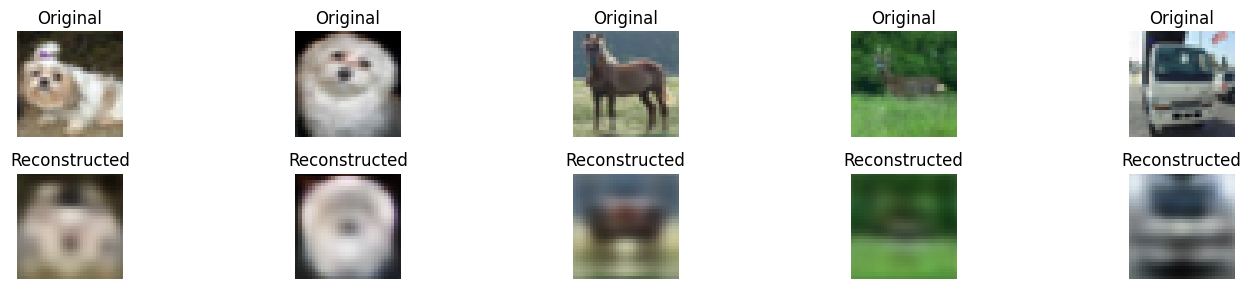

Building the fully convolutional classifier...


Model: "fcn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 512)           │       1,180,1

 Total params: 1,772,330 (6.76 MB)

 Trainable params: 1,769,898 (6.75 MB)

 Non-trainable params: 2,432 (9.50 KB)

Training the classifier...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.1819 - loss: 2.2979

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1839 - loss: 2.2898 - val_accuracy: 0.1800 - val_loss: 2.1744 - learning_rate: 1.0000e-04
Epoch 2/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2198 - loss: 2.0117

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.2305 - loss: 1.9985 - val_accuracy: 0.2060 - val_loss: 2.1113 - learning_rate: 1.0000e-04
Epoch 3/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3572 - loss: 1.8215

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3529 - loss: 1.8190 - val_accuracy: 0.2460 - val_loss: 2.0590 - learning_rate: 1.0000e-04
Epoch 4/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3809 - loss: 1.7675

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3816 - loss: 1.7560 - val_accuracy: 0.2820 - val_loss: 2.0099 - learning_rate: 1.0000e-04
Epoch 5/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3717 - loss: 1.7659

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3767 - loss: 1.7434 - val_accuracy: 0.2960 - val_loss: 1.9933 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4340 - loss: 1.5384

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4340 - loss: 1.5408 - val_accuracy: 0.3100 - val_loss: 1.9904 - learning_rate: 1.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4449 - loss: 1.5036 - val_accuracy: 0.3100 - val_loss: 1.9729 - learning_rate: 1.0000e-04
Epoch 8/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5011 - loss: 1.4771

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5004 - loss: 1.4745 - val_accuracy: 0.3360 - val_loss: 1.9530 - learning_rate: 1.0000e-04
Epoch 9/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4857 - loss: 1.4566

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4835 - loss: 1.4574 - val_accuracy: 0.3420 - val_loss: 1.9071 - learning_rate: 1.0000e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5118 - loss: 1.4268 - val_accuracy: 0.3400 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5447 - loss: 1.3426 - val_accuracy: 0.3360 - val_loss: 1.8706 - learning_rate: 1.0000e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5676 - loss: 1.2849 - val_accuracy: 0.3400 - val_loss: 1.8639 - learning_rate: 1.0000e-04
Epoch 13/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5496 - loss: 1.2687

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5479 - loss: 1.2761 - val_accuracy: 0.3520 - val_loss: 1.8590 - learning_rate: 1.0000e-04
Epoch 14/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5526 - loss: 1.3243

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5511 - loss: 1.3165 - val_accuracy: 0.3600 - val_loss: 1.8540 - learning_rate: 1.0000e-04
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5593 - loss: 1.2748

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5625 - loss: 1.2690 - val_accuracy: 0.3760 - val_loss: 1.8269 - learning_rate: 1.0000e-04
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5652 - loss: 1.2744 - val_accuracy: 0.3700 - val_loss: 1.8053 - learning_rate: 1.0000e-04
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6035 - loss: 1.2030 - val_accuracy: 0.3720 - val_loss: 1.7963 - learning_rate: 1.0000e-04
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6303 - loss: 1.1317 - val_accuracy: 0.3660 - val_loss: 1.7927 - learning_rate: 1.0000e-04
Epoch 19/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6113 - loss: 1.1429

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6075 - loss: 1.1436 - val_accuracy: 0.3820 - val_loss: 1.7728 - learning_rate: 1.0000e-04
Epoch 20/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6000 - loss: 1.1175

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6040 - loss: 1.1222 - val_accuracy: 0.4000 - val_loss: 1.7374 - learning_rate: 1.0000e-04
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6322 - loss: 1.0486 - val_accuracy: 0.3940 - val_loss: 1.7491 - learning_rate: 1.0000e-04
Epoch 22/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6955 - loss: 1.0146

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6867 - loss: 1.0232 - val_accuracy: 0.4100 - val_loss: 1.7439 - learning_rate: 1.0000e-04
Epoch 23/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6214 - loss: 1.0113 - val_accuracy: 0.4080 - val_loss: 1.7392 - learning_rate: 1.0000e-04
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6797 - loss: 0.9660 - val_accuracy: 0.3940 - val_loss: 1.7569 - learning_rate: 1.0000e-04
Epoch 25/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6592 - loss: 0.9761 - val_accuracy: 0.3880 - val_loss: 1.7893 - learning_rate: 1.0000e-04
Epoch 26/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7010 - loss: 0.9449 - val_accuracy: 0.3880 - val_loss: 1.7886 - learning_rate: 5.0000e-05
Epoch 27/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6080 - loss: 1.0346 - val_accuracy: 0.3880 - val_loss: 1.7743 - learning_rate: 5.0000e-05
Epoch 28/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7038 - loss: 0.9183 - va

AttributeError: The layer fcn_classifier has never been called and thus has no defined input.

In [2]:
fcn_classifier, autoencoder, history = main()